# Model Experiments: Feature Selection
This notebook conducts experiments on feature selection.

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import sys
sys.path.insert(0, '../utils')
import model_utils
import geoutils

import logging
import warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

SEED = 42

%load_ext autoreload
%autoreload 2

## File Locations

In [2]:
data_dir = "../data/"
input_file = data_dir + '20200326_dataset.csv'

pos_mask_dir = data_dir + 'pos_masks/'
neg_mask_dir = data_dir + 'neg_masks/'
sentinel_dir = data_dir + 'sentinel2/'

areas = ['maicao', 'riohacha', 'uribia']

## Load Dataset

In [3]:
data = pd.read_csv(input_file).reset_index(drop=True)
print('Data dimensions: {}'.format(data.shape))
print('Class distribution:\n{}'.format(data['target'].value_counts()))
print('Class distribution (normalized):\n{}'.format(data['target'].value_counts()/len(data)))
data.head(3)

Data dimensions: (334524, 112)
Class distribution:
3    248172
2     71796
1     14556
Name: target, dtype: int64
Class distribution (normalized):
3    0.741866
2    0.214621
1    0.043513
Name: target, dtype: float64


,B1_2016,B2_2016,B3_2016,B4_2016,B5_2016,B6_2016,B7_2016,B8_2016,B9_2016,B10_2016,...,savi_2020,mndwi_2020,ui_2020,nbi_2020,brba_2020,nbai_2020,mbi_2020,baei_2020,target,area
0,0.15970,0.13735,0.1531,0.18700,0.2090,0.26320,0.30515,0.26965,0.3327,0.0411,...,0.187614,-0.509745,0.105128,0.239614,0.449106,-0.718433,-0.042537,0.901237,3,0
1,0.15970,0.13905,0.1454,0.17845,0.2090,0.26320,0.30515,0.26395,0.3327,0.0411,...,0.177058,-0.507485,0.105128,0.247826,0.464498,-0.716955,-0.039760,0.911490,3,0
2,0.16675,0.14875,0.1589,0.18605,0.2258,0.27945,0.32070,0.28085,0.3452,0.0416,...,0.179191,-0.524371,0.073259,0.262348,0.446475,-0.722188,-0.033995,0.875915,3,0


## Resample Dataset
Resamples 30,000 negative examples per area.

In [4]:
data_area = []
for area in data['area'].unique():
    neg_sample = data[
        (data['area'] == area) 
        & (data['target'] != 1)
    ].sample(30000, replace=False, random_state=SEED)
    data_area.append(neg_sample)

pos_samples = data[data['target'] == 1]
data_area.append(pos_samples)
data = pd.concat(data_area)

data = data.reset_index(drop=True)
print("Target Distribution per Area: \n{}".format(
    data[data['target'] == 1]['area'].value_counts()
))
print('Area distribution:\n{}'.format(data['area'].value_counts()))
print('Class distribution:\n{}'.format(data['target'].value_counts()))
print('Class distribution (normalized):\n{}'.format(data['target'].value_counts()/len(data)))
data.head(3)

Target Distribution per Area: 
2    10345
1     3501
0      710
Name: area, dtype: int64
Area distribution:
2    40345
1    33501
0    30710
Name: area, dtype: int64
Class distribution:
3    67639
2    22361
1    14556
Name: target, dtype: int64
Class distribution (normalized):
3    0.646916
2    0.213866
1    0.139217
Name: target, dtype: float64


,B1_2016,B2_2016,B3_2016,B4_2016,B5_2016,B6_2016,B7_2016,B8_2016,B9_2016,B10_2016,...,savi_2020,mndwi_2020,ui_2020,nbi_2020,brba_2020,nbai_2020,mbi_2020,baei_2020,target,area
0,0.22620,0.18300,0.1790,0.1831,0.18860,0.2509,0.2981,0.2653,0.3291,0.0431,...,0.231549,-0.594230,0.211756,0.102407,0.321400,-0.798628,-0.067515,1.196927,3,0
1,0.14955,0.12935,0.1270,0.1223,0.13935,0.2424,0.2846,0.2662,0.3236,0.0388,...,0.219911,-0.529955,0.153344,0.208832,0.384915,-0.705785,-0.057656,0.871430,3,0
2,0.16860,0.15970,0.1612,0.1616,0.18550,0.3246,0.3985,0.3127,0.4143,0.0454,...,0.205571,-0.536190,0.136678,0.237628,0.413957,-0.706110,-0.052031,0.864904,3,0


## Machine Learning Pipeline

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
SEED = 42

## Define Features and Target Label

In [8]:
# Get target and feature columns
label = 'target'
features = [column for column in data.columns[:-2] if 'mndwi' not in column]

# Convert target labels to binary
data[label] = data[label].replace({2:0, 3:0})

print('Data dimensions: {}'.format(data.shape))
print('Class distribution:\n{}'.format(data['target'].value_counts()))

Data dimensions: (104556, 112)
Class distribution:
0    90000
1    14556
Name: target, dtype: int64


## Logistic Regression

--------------------
| NUM FEATURES: 100 |
--------------------
Fitting estimator with 105 features.

Average F1 Score: 0.7468
Average Kappa statistic: 0.7261
Average Precision: 0.7766
Average Recall: 0.7643
Average Accuracy: 0.9632

--------------------
| NUM FEATURES: 90 |
--------------------
Fitting estimator with 105 features.
Fitting estimator with 95 features.

Average F1 Score: 0.7500
Average Kappa statistic: 0.7297
Average Precision: 0.7795
Average Recall: 0.7671
Average Accuracy: 0.9639

--------------------
| NUM FEATURES: 80 |
--------------------
Fitting estimator with 105 features.
Fitting estimator with 95 features.
Fitting estimator with 85 features.

Average F1 Score: 0.7540
Average Kappa statistic: 0.7344
Average Precision: 0.7839
Average Recall: 0.7675
Average Accuracy: 0.9651

--------------------
| NUM FEATURES: 70 |
--------------------
Fitting estimator with 105 features.
Fitting estimator with 95 features.
Fitting estimator with 85 features.
Fitting estimator wi

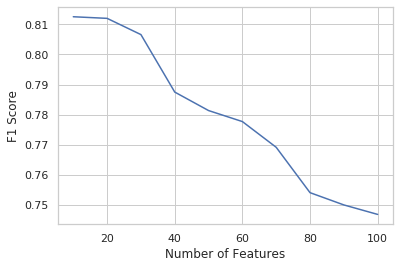

Best 10 Features: ['nbi_2016', 'B1_2017', 'B2_2018', 'B12_2018', 'B1_2019', 'B10_2019', 'B12_2019', 'savi_2019', 'B1_2020', 'B12_2020']


In [76]:
lr = LogisticRegression()
lr_best_features, lr_feat_dict = model_utils.get_best_features(
    lr, data, features, label, scale=True, verbose=1, plot=True
)

## Random Forest Classifier

--------------------
| NUM FEATURES: 100 |
--------------------
Fitting estimator with 105 features.

Average F1 Score: 0.4934
Average Kappa statistic: 0.4575
Average Precision: 0.7910
Average Recall: 0.4293
Average Accuracy: 0.9021

--------------------
| NUM FEATURES: 90 |
--------------------
Fitting estimator with 105 features.
Fitting estimator with 95 features.

Average F1 Score: 0.4905
Average Kappa statistic: 0.4558
Average Precision: 0.7940
Average Recall: 0.4207
Average Accuracy: 0.9017

--------------------
| NUM FEATURES: 80 |
--------------------
Fitting estimator with 105 features.
Fitting estimator with 95 features.
Fitting estimator with 85 features.

Average F1 Score: 0.5018
Average Kappa statistic: 0.4658
Average Precision: 0.7848
Average Recall: 0.4411
Average Accuracy: 0.9036

--------------------
| NUM FEATURES: 70 |
--------------------
Fitting estimator with 105 features.
Fitting estimator with 95 features.
Fitting estimator with 85 features.
Fitting estimator wi

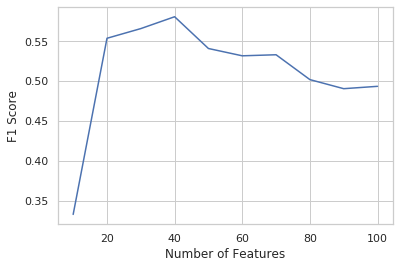

Best 40 Features: ['B3_2016', 'B4_2016', 'B5_2016', 'B11_2016', 'B12_2016', 'ndvi_2016', 'ndbi_2016', 'savi_2016', 'ui_2016', 'nbi_2016', 'nbai_2016', 'mbi_2016', 'baei_2016', 'B1_2017', 'B5_2017', 'B11_2018', 'B12_2018', 'ndbi_2018', 'nbi_2018', 'baei_2018', 'B1_2019', 'B2_2019', 'B5_2019', 'B6_2019', 'B9_2019', 'B10_2019', 'B11_2019', 'B12_2019', 'ndbi_2019', 'nbi_2019', 'baei_2019', 'B1_2020', 'B5_2020', 'B7_2020', 'B10_2020', 'B11_2020', 'B12_2020', 'nbi_2020', 'mbi_2020', 'baei_2020']


In [77]:
rf = RandomForestClassifier(n_estimators=100, max_depth=8, n_jobs=-1, random_state=SEED)
rf_best_features, rf_feat_dict = model_utils.get_best_features(
    rf, data, features, label, scale=True, verbose=1, plot=True
)

## Linear Support Vector Machines

--------------------
| NUM FEATURES: 100 |
--------------------
Fitting estimator with 105 features.

Average F1 Score: 0.7158
Average Kappa statistic: 0.6924
Average Precision: 0.7948
Average Recall: 0.7027
Average Accuracy: 0.9580

--------------------
| NUM FEATURES: 90 |
--------------------
Fitting estimator with 105 features.
Fitting estimator with 95 features.

Average F1 Score: 0.7196
Average Kappa statistic: 0.6964
Average Precision: 0.7966
Average Recall: 0.7046
Average Accuracy: 0.9586

--------------------
| NUM FEATURES: 80 |
--------------------
Fitting estimator with 105 features.
Fitting estimator with 95 features.
Fitting estimator with 85 features.

Average F1 Score: 0.7337
Average Kappa statistic: 0.7117
Average Precision: 0.7959
Average Recall: 0.7176
Average Accuracy: 0.9613

--------------------
| NUM FEATURES: 70 |
--------------------
Fitting estimator with 105 features.
Fitting estimator with 95 features.
Fitting estimator with 85 features.
Fitting estimator wi

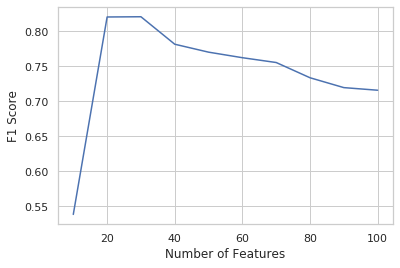

Best 30 Features: ['B2_2016', 'B11_2016', 'B12_2016', 'nbi_2016', 'mbi_2016', 'B1_2017', 'B5_2017', 'B11_2017', 'ui_2017', 'B10_2018', 'ui_2018', 'nbai_2018', 'mbi_2018', 'B2_2019', 'B6_2019', 'B7_2019', 'B9_2019', 'B10_2019', 'B12_2019', 'ndbi_2019', 'savi_2019', 'nbi_2019', 'brba_2019', 'mbi_2019', 'B1_2020', 'B4_2020', 'B6_2020', 'B9_2020', 'B12_2020', 'savi_2020']


In [79]:
lsvc = LinearSVC(random_state=SEED)
lsvc_best_features, lsvc_feat_dict = model_utils.get_best_features(
    lsvc, data, features, label, scale=True, verbose=1, calibrate=True, plot=True
)

## LightGBM

--------------------
| NUM FEATURES: 100 |
--------------------
Fitting estimator with 105 features.

Average F1 Score: 0.5608
Average Kappa statistic: 0.5221
Average Precision: 0.7885
Average Recall: 0.4863
Average Accuracy: 0.9113

--------------------
| NUM FEATURES: 90 |
--------------------
Fitting estimator with 105 features.
Fitting estimator with 95 features.

Average F1 Score: 0.5628
Average Kappa statistic: 0.5243
Average Precision: 0.7874
Average Recall: 0.4945
Average Accuracy: 0.9125

--------------------
| NUM FEATURES: 80 |
--------------------
Fitting estimator with 105 features.
Fitting estimator with 95 features.
Fitting estimator with 85 features.

Average F1 Score: 0.5720
Average Kappa statistic: 0.5324
Average Precision: 0.7744
Average Recall: 0.5144
Average Accuracy: 0.9148

--------------------
| NUM FEATURES: 70 |
--------------------
Fitting estimator with 105 features.
Fitting estimator with 95 features.
Fitting estimator with 85 features.
Fitting estimator wi

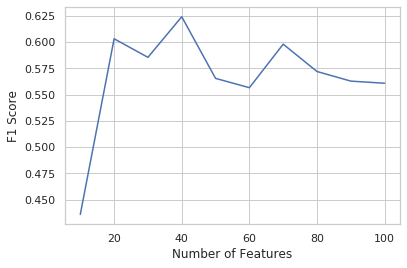

Best 40 Features: ['B1_2016', 'B3_2016', 'B5_2016', 'B9_2016', 'B10_2016', 'B11_2016', 'B12_2016', 'ndvi_2016', 'ndbi_2016', 'ui_2016', 'nbi_2016', 'B1_2017', 'B5_2017', 'B9_2017', 'B10_2017', 'B11_2017', 'ndbi_2017', 'ui_2017', 'brba_2017', 'B1_2018', 'B9_2018', 'B10_2018', 'ndbi_2018', 'ui_2018', 'B1_2019', 'B6_2019', 'B9_2019', 'B10_2019', 'B11_2019', 'B12_2019', 'ndvi_2019', 'ndbi_2019', 'ui_2019', 'mbi_2019', 'B1_2020', 'B10_2020', 'B12_2020', 'ndbi_2020', 'ui_2020', 'mbi_2020']


In [9]:
lgbc = LGBMClassifier(n_estimators=100)
lgbc_best_features, lgbc_feat_dict = model_utils.get_best_features(
    lgbc, data, features, label, scale=True, verbose=1, plot=True
)